Found 100 parquet files. Loading...
Processing Big Room...
  Saved plot -> special_issue_plots\Big_Room_curve.png


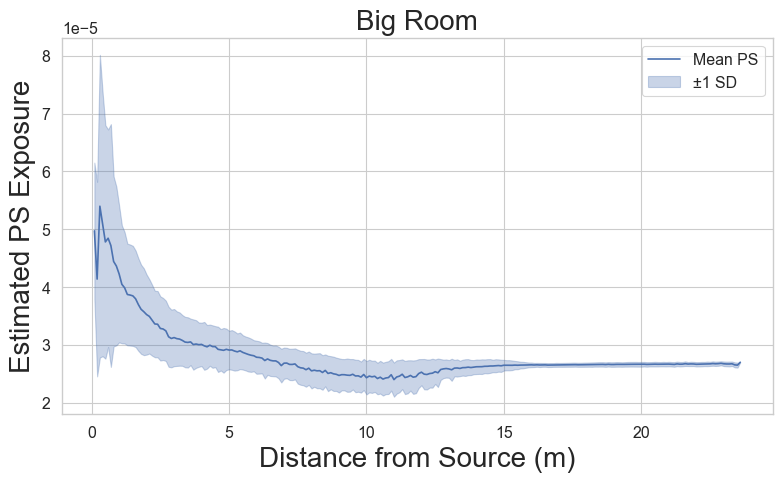

Processing Staff Room...
  Saved plot -> special_issue_plots\Staff_Room_curve.png


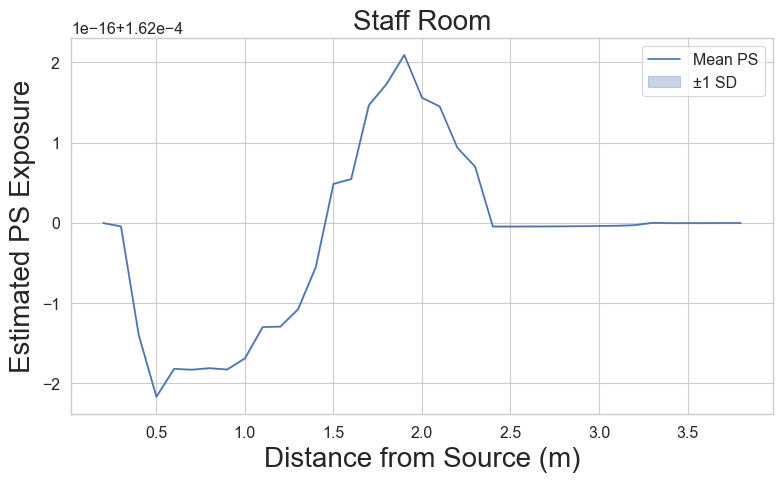

Processing Principal Office...
  Saved plot -> special_issue_plots\Principal_Office_curve.png


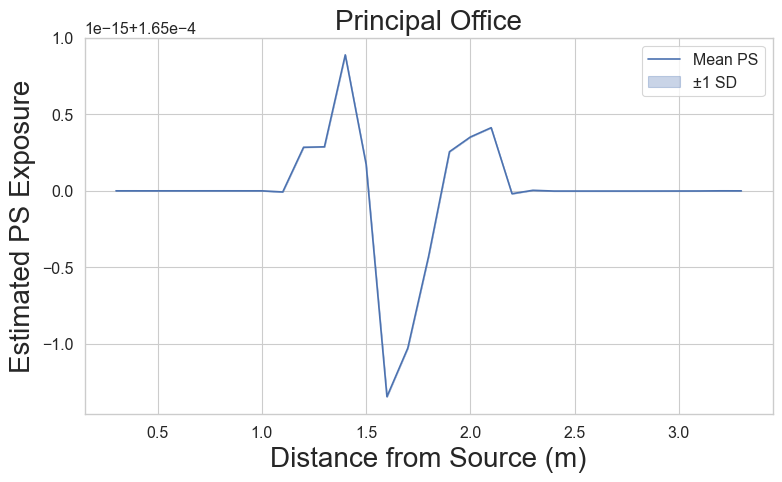

Processing Kitchen...
  Saved plot -> special_issue_plots\Kitchen_curve.png


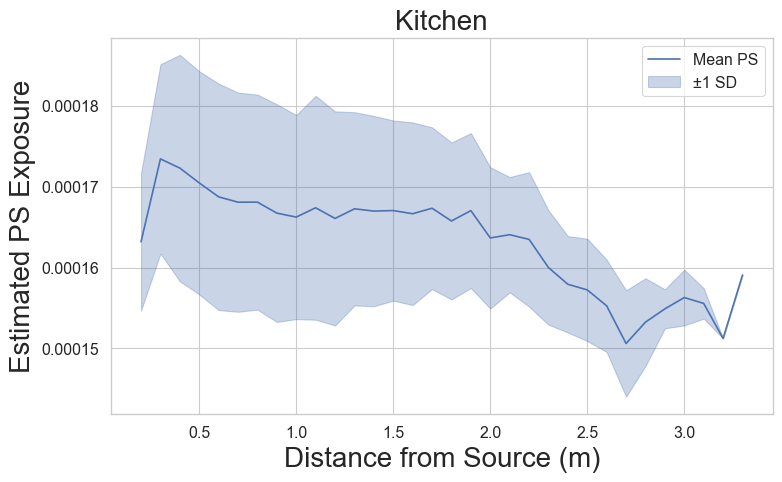

Processing Toilet...
  Saved plot -> special_issue_plots\Toilet_curve.png


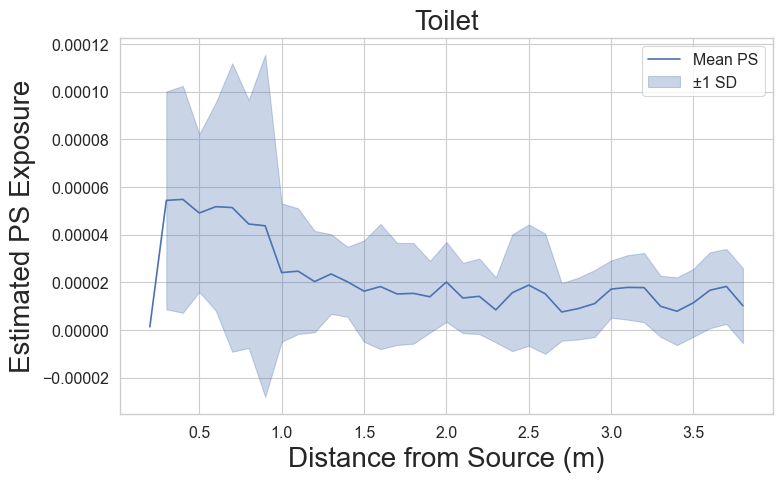

Generating combined overlay plot...
Saved combined plot -> special_issue_plots\All_Rooms_Curve.png


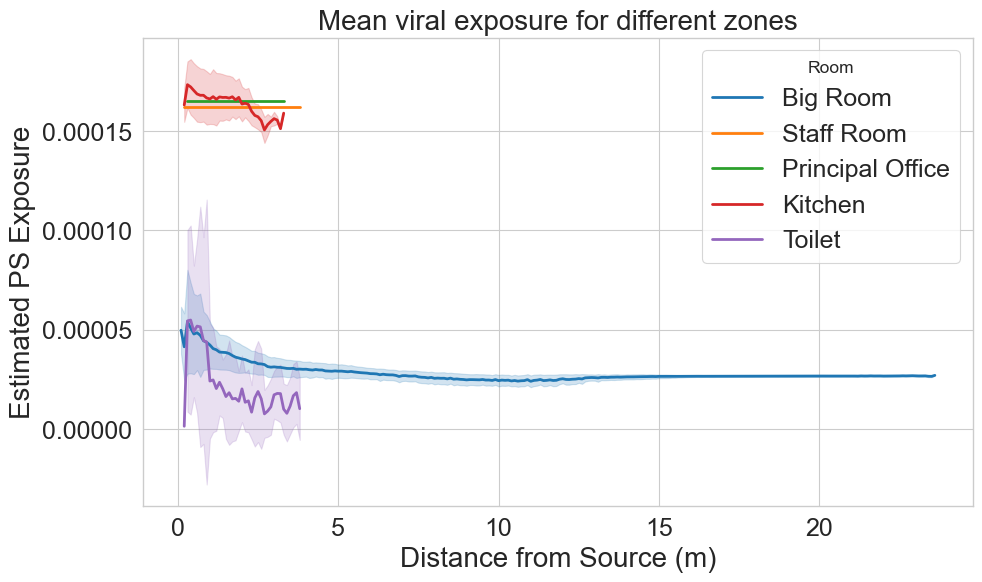

In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
id_categories = {
    'K1-Teachers': [178, 179],
    'K1-Students': [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199],
    'N2-Teachers': [200, 201],
    'N2-Students': [202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216],
    'N1-Teachers': [82, 251],
    'N1-Students': [83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94],
    'K2-Teachers': [176, 177],
    'K2-Students': [95, 96, 97, 98, 99, 100, 107, 114, 115, 116, 117, 118, 119, 135, 136, 137, 138, 139, 140, 145, 146, 147, 148, 158, 165],
    'Assistants':  [250, 252, 253, 254]
}

def plot_mean_curve_by_room_save_named(directory="./ps_results_daily/ps_individual",
                                       output_dir="./special_issue_plots",
                                       file_prefix="daily_",
                                       file_suffix="_pl_student.parquet",
                                       bin_width=0.5,
                                       max_points_per_room=900_000_000,
                                       show_plots=True):
    """
    Create separate mean ±1 SD curve plots for each room showing ps_estimated vs. dist.
    Also shows a combined plot overlaying all rooms.

    Parameters
    ----------
    directory : str
        Directory containing parquet files.
    output_dir : str
        Directory to save output figures.
    file_prefix : str
        Prefix of parquet files (e.g. 'daily_').
    file_suffix : str
        Suffix of parquet files (e.g. '_pl.parquet').
    bin_width : float
        Distance bin width in meters.
    max_points_per_room : int
        Max rows to use per room (for performance).
    show_plots : bool
        Whether to display plots interactively.
    """

    room_labels = {
        0: "Big Room",
        1: "Staff Room",
        2: "Principal Office",
        3: "Kitchen",
        4: "Toilet"
    }

    # --- Step 1: Collect parquet files ---
    files = sorted(Path(directory).glob(f"{file_prefix}[0-9]*{file_suffix}"))
    if not files:
        raise FileNotFoundError("No parquet files found.")
    print(f"Found {len(files)} parquet files. Loading...")

    # --- Step 2: Load relevant columns efficiently ---
    df_list = [pl.read_parquet(f, columns=["dist", "ps_estimated", "room"]) for f in files]
    df_all = pl.concat(df_list)

    # --- Step 3: Filter valid data ---
    df_all = df_all.filter(pl.col("dist").is_finite() & pl.col("ps_estimated").is_finite())

    # --- Step 4: Ensure output directory exists ---
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # --- Step 5: Unique rooms ---
    unique_rooms = sorted(df_all["room"].unique())

    sns.set_theme(style="whitegrid", context="paper", font_scale=1.3)

    # To store curves for final combined plot
    combined_curves = []

    # --- Step 6: Process and plot each room individually ---
    for room in unique_rooms:
        room_name = room_labels.get(int(room), f"Room_{room}")
        print(f"Processing {room_name}...")

        # Filter for this room
        df_room = df_all.filter(pl.col("room") == room)

        # Optional downsample
        n_rows = df_room.height
        if n_rows > max_points_per_room:
            df_room = df_room.sample(n=max_points_per_room, seed=42)
            print(f"  Downsampled from {n_rows:,} → {max_points_per_room:,}")

        # Bin distances and compute mean ± SD
        df_binned = (
            df_room
            .with_columns(((pl.col("dist") / bin_width).floor() * bin_width).alias("dist_bin"))
            .group_by("dist_bin")
            .agg([
                pl.mean("ps_estimated").alias("mean_ps"),
                pl.std("ps_estimated").alias("sd_ps"),
                pl.len().alias("count")
            ])
            .sort("dist_bin")
        )

        df_plot = df_binned.to_pandas()
        df_plot["room_name"] = room_name  # Keep for combined plot
        combined_curves.append(df_plot)

        # --- Individual plot ---
        plt.figure(figsize=(8, 5))
        plt.plot(df_plot["dist_bin"], df_plot["mean_ps"], color="C0", label="Mean PS")
        plt.fill_between(
            df_plot["dist_bin"],
            df_plot["mean_ps"] - df_plot["sd_ps"],
            df_plot["mean_ps"] + df_plot["sd_ps"],
            color="C0",
            alpha=0.3,
            label="±1 SD"
        )

        plt.xlabel("Distance from Source (m)", fontsize=20)
        plt.ylabel("Estimated PS Exposure", fontsize=20)
        plt.title(room_name, fontsize=20)
        plt.legend()
        plt.tight_layout()

        # --- Save plot ---
        safe_name = room_name.replace(" ", "_")
        filename = Path(output_dir) / f"{safe_name}_curve.png"
        plt.savefig(filename, dpi=300)
        print(f"  Saved plot -> {filename}")

        if show_plots:
            plt.show()
        else:
            plt.close()

    # --- Step 7: Combined plot of all rooms ---
    print("Generating combined overlay plot...")
    plt.figure(figsize=(10, 6))

    colors = sns.color_palette("tab10", len(combined_curves))

    for df_plot, color in zip(combined_curves, colors):
        plt.plot(df_plot["dist_bin"], df_plot["mean_ps"],
                 label=df_plot["room_name"].iloc[0],
                 color=color, linewidth=2)
        plt.fill_between(
            df_plot["dist_bin"],
            df_plot["mean_ps"] - df_plot["sd_ps"],
            df_plot["mean_ps"] + df_plot["sd_ps"],
            color=color,
            alpha=0.2
        )

    plt.xlabel("Distance from Source (m)", fontsize=20)
    plt.ylabel("Estimated PS Exposure", fontsize=20)
    plt.title("Mean viral exposure for different zones", fontsize=20)
    plt.legend(title="Room", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()

    combined_path = Path(output_dir) / "All_Rooms_Curve.png"
    plt.savefig(combined_path, dpi=600)
    print(f"Saved combined plot -> {combined_path}")

    if show_plots:
        plt.show()
    else:
        plt.close()


# Example usage
plot_mean_curve_by_room_save_named(show_plots=True, bin_width=0.1)


Found 100 parquet files. Loading...
Processing Big Room...
  Saved plot -> special_issue_plots\Big_Room_curve_by_category.png


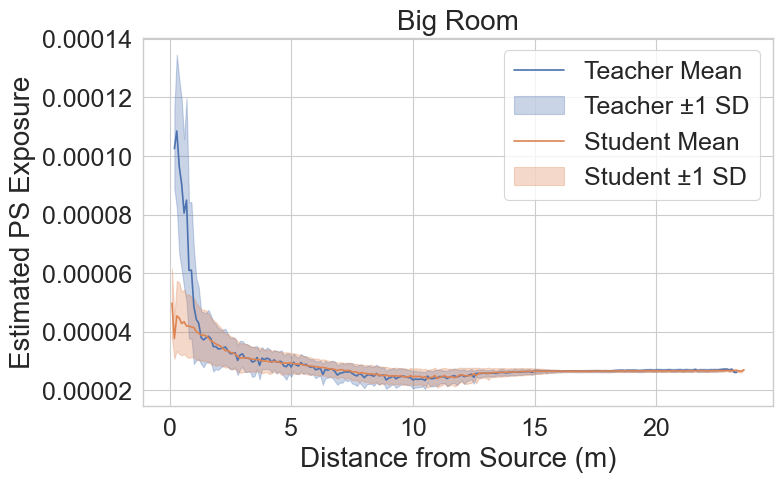

Processing Staff Room...
  Saved plot -> special_issue_plots\Staff_Room_curve_by_category.png


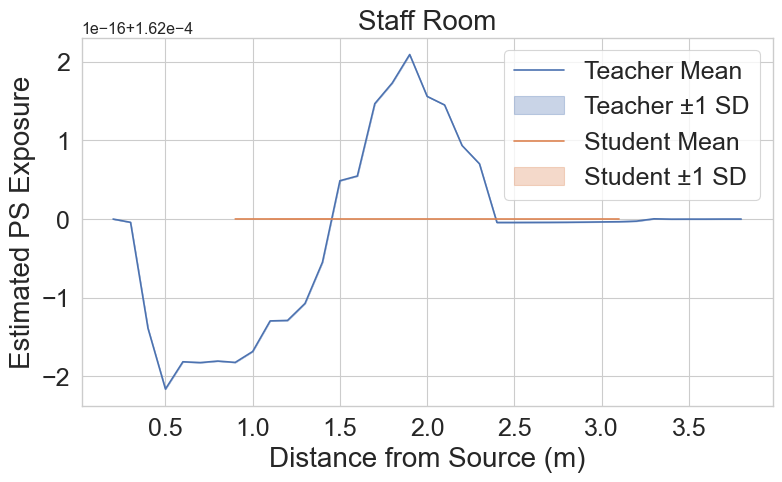

Processing Principal Office...
  Saved plot -> special_issue_plots\Principal_Office_curve_by_category.png


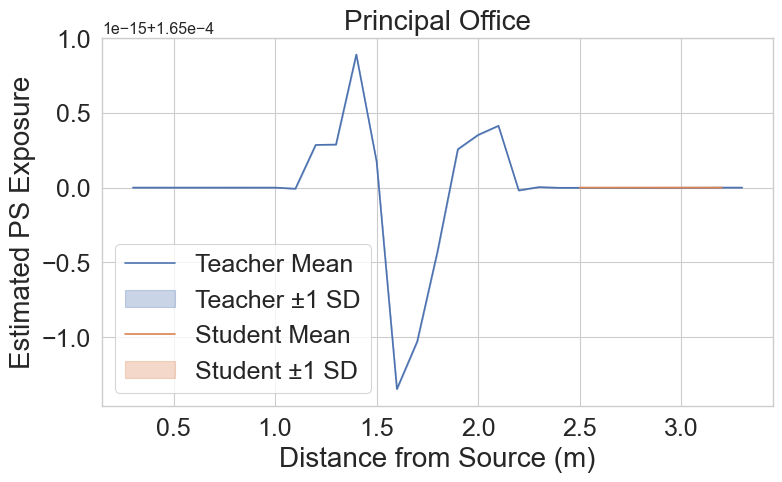

Processing Kitchen...
  Saved plot -> special_issue_plots\Kitchen_curve_by_category.png


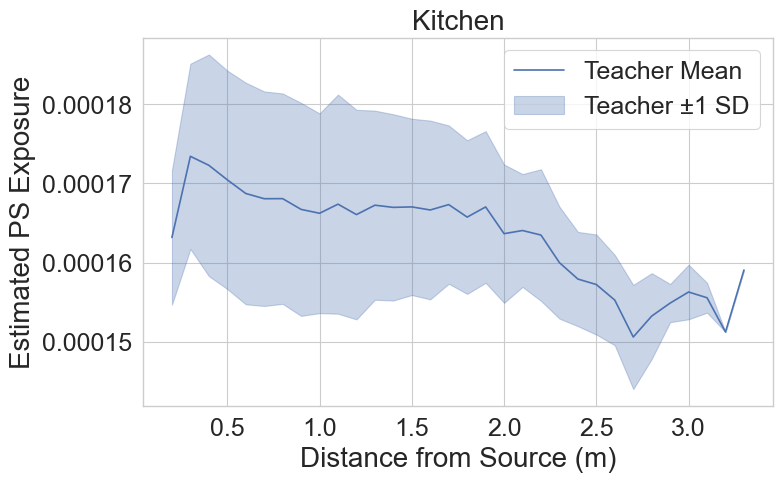

Processing Toilet...
  Saved plot -> special_issue_plots\Toilet_curve_by_category.png


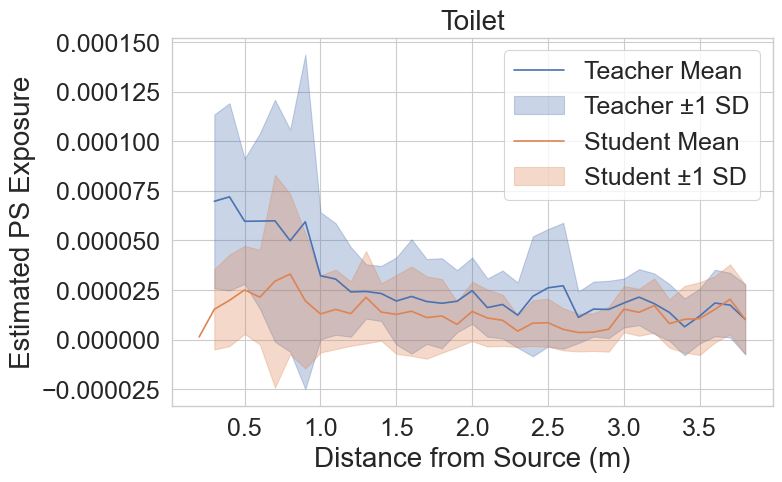

Generating combined overlay plot...
Saved combined plot -> special_issue_plots\All_Rooms_Curve_by_Category.png


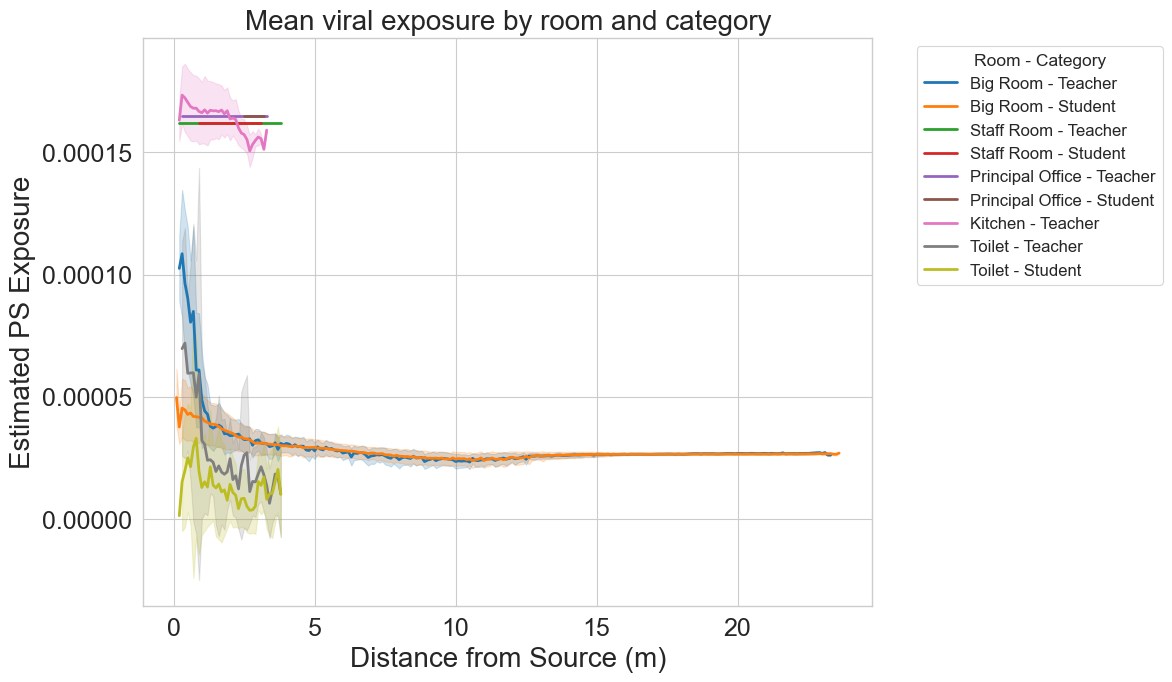

In [2]:
id_categories = {
    'Teacher': [178, 179,200, 201, 82, 251, 176, 177, 250, 252, 253, 254],
    'Student': [95, 96, 97, 98, 99, 100, 107, 114, 115, 116, 117, 118, 119, 135, 136, 137, 138, 139, 140, 145, 146, 147, 148, 158, 165,83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216],
}
def plot_mean_curve_by_room_save_named_by_category(
        directory="./ps_results_daily/ps_individual",
        output_dir="./special_issue_plots",
        file_prefix="daily_",
        file_suffix="_pl_student.parquet",
        bin_width=0.5,
        max_points_per_room=90_000_000,
        show_plots=True):
    """
    Create separate mean ±1 SD curve plots for each room showing ps_estimated vs. dist,
    split by category (Teacher vs Student). Also shows a combined plot overlaying all rooms.

    Parameters
    ----------
    directory : str
        Directory containing parquet files.
    output_dir : str
        Directory to save output figures.
    file_prefix : str
        Prefix of parquet files (e.g. 'daily_').
    file_suffix : str
        Suffix of parquet files (e.g. '_pl.parquet').
    bin_width : float
        Distance bin width in meters.
    max_points_per_room : int
        Max rows to use per room (for performance).
    show_plots : bool
        Whether to display plots interactively.
    """

        # --- Plot aesthetics ---
    sns.set_theme(style="whitegrid", context="paper")
    plt.rcParams.update({
        "axes.labelsize": 18,
        "axes.titlesize": 24,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "legend.fontsize": 14,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"]
    })

    room_labels = {
        0: "Big Room",
        1: "Staff Room",
        2: "Principal Office",
        3: "Kitchen",
        4: "Toilet"
    }

    # --- Step 1: Collect parquet files ---
    files = sorted(Path(directory).glob(f"{file_prefix}[0-9]*{file_suffix}"))
    if not files:
        raise FileNotFoundError("No parquet files found.")
    print(f"Found {len(files)} parquet files. Loading...")

    # --- Step 2: Load relevant columns efficiently ---
    df_list = [pl.read_parquet(f, columns=["dist", "ps_estimated", "room", "id"]) for f in files]
    df_all = pl.concat(df_list)

    # --- Step 3: Filter valid data ---
    df_all = df_all.filter(pl.col("dist").is_finite() & pl.col("ps_estimated").is_finite())

    # --- Step 4: Ensure output directory exists ---
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # --- Step 5: Unique rooms ---
    unique_rooms = sorted(df_all["room"].unique())

    sns.set_theme(style="whitegrid", context="paper", font_scale=1.3)

    # To store curves for final combined plot
    combined_curves = []

    # --- Step 6: Process and plot each room individually ---
    for room in unique_rooms:
        room_name = room_labels.get(int(room), f"Room_{room}")
        print(f"Processing {room_name}...")

        df_room = df_all.filter(pl.col("room") == room)

        # Optional downsample
        n_rows = df_room.height
        if n_rows > max_points_per_room:
            df_room = df_room.sample(n=max_points_per_room, seed=42)
            print(f"  Downsampled from {n_rows:,} → {max_points_per_room:,}")

        plt.figure(figsize=(8, 5))
        colors = {"Teacher": "C0", "Student": "C1"}

        for category, ids in id_categories.items():
            df_cat = df_room.filter(pl.col("id").is_in(ids))
            if df_cat.height == 0:
                continue

            # Bin distances and compute mean ± SD
            df_binned = (
                df_cat
                .with_columns(((pl.col("dist") / bin_width).floor() * bin_width).alias("dist_bin"))
                .group_by("dist_bin")
                .agg([
                    pl.mean("ps_estimated").alias("mean_ps"),
                    pl.std("ps_estimated").alias("sd_ps"),
                    pl.len().alias("count")
                ])
                .sort("dist_bin")
            )

            df_plot = df_binned.to_pandas()
            df_plot["category"] = category  # Keep for combined plot
            combined_curves.append(df_plot.assign(room_name=room_name))

            # Plot
            plt.plot(df_plot["dist_bin"], df_plot["mean_ps"], color=colors[category], label=f"{category} Mean")
            plt.fill_between(
                df_plot["dist_bin"],
                df_plot["mean_ps"] - df_plot["sd_ps"],
                df_plot["mean_ps"] + df_plot["sd_ps"],
                color=colors[category],
                alpha=0.3,
                label=f"{category} ±1 SD"
            )

        plt.xlabel("Distance from Source (m)", fontsize=20)
        plt.ylabel("Estimated PS Exposure", fontsize=20)
        plt.title(room_name, fontsize=20)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=18)
        plt.tight_layout()

        # --- Save plot ---
        safe_name = room_name.replace(" ", "_")
        filename = Path(output_dir) / f"{safe_name}_curve_by_category.png"
        plt.savefig(filename, dpi=300)
        print(f"  Saved plot -> {filename}")

        if show_plots:
            plt.show()
        else:
            plt.close()

    # --- Step 7: Combined plot of all rooms by category ---
    print("Generating combined overlay plot...")
    plt.figure(figsize=(12, 7))

    colors = sns.color_palette("tab10", 10)  # More colors for multiple rooms/categories

    for i, df_plot in enumerate(combined_curves):
        plt.plot(df_plot["dist_bin"], df_plot["mean_ps"],
                 label=f"{df_plot['room_name'].iloc[0]} - {df_plot['category'].iloc[0]}",
                 color=colors[i % len(colors)], linewidth=2)
        plt.fill_between(
            df_plot["dist_bin"],
            df_plot["mean_ps"] - df_plot["sd_ps"],
            df_plot["mean_ps"] + df_plot["sd_ps"],
            color=colors[i % len(colors)],
            alpha=0.2
        )

    plt.xlabel("Distance from Source (m)", fontsize=20)
    plt.ylabel("Estimated PS Exposure", fontsize=20)
    plt.title("Mean viral exposure by room and category", fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(title="Room - Category", fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()

    combined_path = Path(output_dir) / "All_Rooms_Curve_by_Category.png"
    plt.savefig(combined_path, dpi=300)
    print(f"Saved combined plot -> {combined_path}")

    if show_plots:
        plt.show()
    else:
        plt.close()
plot_mean_curve_by_room_save_named_by_category(show_plots=True, bin_width=0.1)

Found 100 parquet files. Loading...


C:\Users\wenyu\AppData\Local\Temp\ipykernel_41748\570491306.py:94: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("count")


{'asymptote': 2.5389964287927404e-05, 'params': {'a': 2.5389964287927404e-05, 'b': 9.123220093011681e-05, 'c': 0.5817408503895455}, 'fitted_curve': array([1.16622165e-04, 9.35963021e-05, 7.63818780e-05, 6.35121586e-05,
       5.38905949e-05, 4.66973932e-05, 4.13196654e-05, 3.72992087e-05,
       3.42934648e-05, 3.20463329e-05, 3.03663490e-05, 2.91103719e-05,
       2.81713877e-05, 2.74693913e-05, 2.69445700e-05, 2.65522070e-05,
       2.62588715e-05, 2.60395702e-05, 2.58756179e-05, 2.57530450e-05,
       2.56614080e-05, 2.55928990e-05, 2.55416808e-05, 2.55033895e-05,
       2.54747624e-05, 2.54533604e-05, 2.54373600e-05, 2.54253979e-05,
       2.54164549e-05, 2.54097690e-05, 2.54047706e-05, 2.54010336e-05,
       2.53982399e-05, 2.53961512e-05, 2.53945897e-05, 2.53934223e-05,
       2.53925496e-05, 2.53918971e-05, 2.53914093e-05, 2.53910446e-05,
       2.53907719e-05, 2.53905681e-05, 2.53904157e-05, 2.53903018e-05,
       2.53902166e-05, 2.53901529e-05, 2.53901053e-05, 2.53900697e-05])

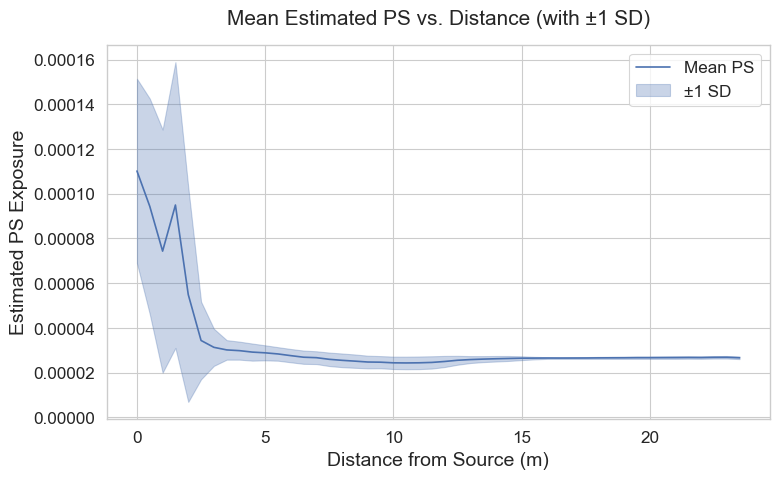

In [3]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np


from scipy.optimize import curve_fit

def estimate_asymptote_exp(df_plot):
    """
    Fit an exponential decay with asymptote: y = a + b * exp(-c * x)
    Returns: dict with asymptote (a), decay rate (c), and fit stats.
    """
    x = df_plot["dist_bin"].values.astype(float)
    y = df_plot["mean_ps"].values.astype(float)

    def model(x, a, b, c):
        return a + b * np.exp(-c * x)

    # initial guesses
    a0 = y[-1]                     # last value ~ asymptote
    b0 = y[0] - y[-1]              # difference from start to end
    c0 = 1.0 / (max(x) - min(x))   # rough rate guess
    p0 = [a0, b0, c0]

    popt, pcov = curve_fit(model, x, y, p0=p0, bounds=([-np.inf, -np.inf, 0], [np.inf, np.inf, np.inf]))

    a, b, c = popt
    y_fit = model(x, *popt)

    return {
        "asymptote": a,
        "params": {"a": a, "b": b, "c": c},
        "fitted_curve": y_fit,
    }


def plot_mean_distance_against_ps(directory="./ps_results_daily/ps_individual",
                                  output_dir="./special_issue_plots",
                                  file_prefix="daily_",
                                  file_suffix="_pl.parquet",
                                  bin_width=0.5,
                                  max_points=90_000_000):
    """
    Plot the mean and standard deviation of ps_estimated against distance.
    Produces a smooth curve (mean) with shaded ±1 SD band.

    Parameters
    ----------
    directory : str
        Directory containing parquet files.
    output_dir : str
        Directory to save the output figure.
    file_prefix : str
        File prefix (e.g., 'daily_').
    file_suffix : str
        File suffix (e.g., '_pl.parquet').
    bin_width : float
        Width of distance bins (in meters) for averaging.
    max_points : int
        Maximum number of rows to process (for performance).
    """

    # --- Step 1: Collect parquet files ---
    files = sorted(Path(directory).glob(f"{file_prefix}[0-9]*{file_suffix}"))
    if not files:
        raise FileNotFoundError(f"No parquet files found matching pattern {file_prefix}*{file_suffix} in {directory}")

    print(f"Found {len(files)} parquet files. Loading...")

    # --- Step 2: Load and concatenate efficiently ---
    df_list = [pl.read_parquet(f, columns=["dist", "ps_estimated"]) for f in files]
    df_all = pl.concat(df_list)

    # --- Step 3: Filter valid data ---
    df_all = df_all.filter(pl.col("dist").is_finite() & pl.col("ps_estimated").is_finite())

    # --- Step 4: Downsample if too large ---
    n_rows = df_all.height
    if n_rows > max_points:
        df_all = df_all.sample(n=max_points, seed=42)
        print(f"Downsampled to {max_points:,} points for visualization (from {n_rows:,})")

    # --- Step 5: Bin distances and compute statistics ---
    df_binned = (
        df_all
        .with_columns(((pl.col("dist") / bin_width).floor() * bin_width).alias("dist_bin"))
        .group_by("dist_bin")
        .agg([
            pl.mean("ps_estimated").alias("mean_ps"),
            pl.std("ps_estimated").alias("sd_ps"),
            pl.count().alias("count")
        ])
        .sort("dist_bin")
    )

    df_plot = df_binned.to_pandas()

    # --- Step 6: Plot aesthetics ---
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)
    plt.figure(figsize=(8, 5))

    # --- Step 7: Plot mean curve ---
    plt.plot(df_plot["dist_bin"], df_plot["mean_ps"], color="C0", label="Mean PS")

    # --- Step 8: Fill ±1 SD band ---
    plt.fill_between(
        df_plot["dist_bin"],
        df_plot["mean_ps"] - df_plot["sd_ps"],
        df_plot["mean_ps"] + df_plot["sd_ps"],
        color="C0",
        alpha=0.3,
        label="±1 SD"
    )

    # --- Step 9: Labeling & layout ---
    plt.xlabel("Distance from Source (m)", fontsize=14)
    plt.ylabel("Estimated PS Exposure", fontsize=14)
    plt.title("Mean Estimated PS vs. Distance (with ±1 SD)", fontsize=15, pad=15)
    plt.legend()
    plt.tight_layout()
    print(estimate_asymptote_exp(df_plot))
    # --- Step 10: Save plot ---
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    filename = Path(output_dir) / "distance_vs_viral_exposure_curve.png"
    plt.savefig(filename, dpi=300)
    print(f"Saved plot -> {filename}")
    
    plt.show()
plot_mean_distance_against_ps()

Found 100 parquet files. Loading...
Downsampled to 5,000,000 points (from 83,614,442)
Saved individual plot -> special_issue_plots\big_room_scatter_log.png
Saved individual plot -> special_issue_plots\staff_room_scatter_log.png
Saved individual plot -> special_issue_plots\principal_office_scatter_log.png
Saved individual plot -> special_issue_plots\kitchen_scatter_log.png
Saved individual plot -> special_issue_plots\toilet_scatter_log.png


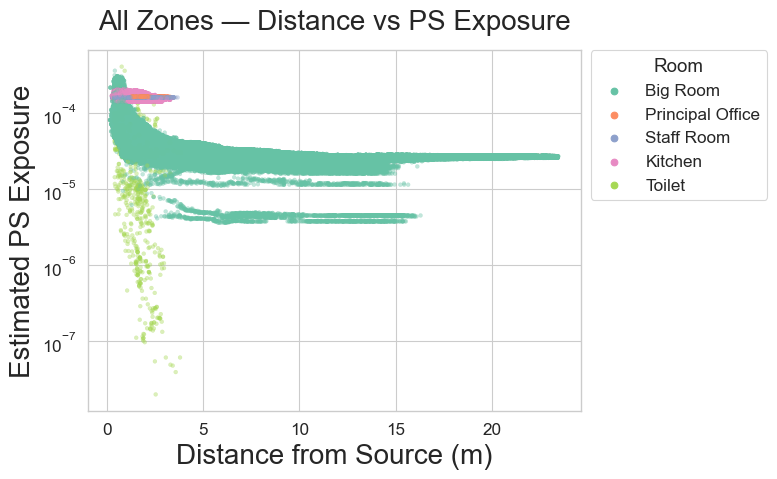

Saved combined plot -> special_issue_plots\all_zone_scatter_log.png


In [4]:
def plot_scatter_all_rooms_combined(
    directory="./ps_results_daily/ps_individual",
    file_prefix="daily_",
    file_suffix="_pl.parquet",
    output_dir="./special_issue_plots",
    max_points=5_000_000,
    smooth=True,
    log_x=False,
    log_y=False
):
    """
    Plot scatter plots for each room individually, then one combined plot with all rooms.
    Supports optional logarithmic scaling on x and/or y axes.
    """

    from pathlib import Path
    import polars as pl
    import seaborn as sns
    import matplotlib.pyplot as plt
    import os

    room_labels = {
        0: "Big Room",
        1: "Staff Room",
        2: "Principal Office",
        3: "Kitchen",
        4: "Toilet"
    }

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # --- Step 1: Collect parquet files ---
    files = sorted(Path(directory).glob(f"{file_prefix}[0-9]*{file_suffix}"))
    if not files:
        raise FileNotFoundError("No parquet files found.")
    print(f"Found {len(files)} parquet files. Loading...")

    # --- Step 2: Load relevant columns efficiently ---
    df_list = [pl.read_parquet(f, columns=["dist", "ps_estimated", "room"]) for f in files]
    df_all = pl.concat(df_list)

    # --- Step 3: Clean and label ---
    df_all = df_all.filter(pl.col("dist").is_finite())
    df_all = df_all.with_columns(pl.col("room").replace_strict(room_labels).alias("room_label"))

    # --- Step 4: Downsample ---
    n_rows = df_all.height
    if n_rows > max_points:
        df_all = df_all.sample(n=max_points, seed=42)
        print(f"Downsampled to {max_points:,} points (from {n_rows:,})")

    # --- Step 5: Convert to pandas for plotting ---
    df_plot = df_all.to_pandas()

    # --- Step 6: Seaborn theme ---
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)
    palette = sns.color_palette("Set2", n_colors=len(room_labels))

    # --- Step 7: Plot each room individually ---
    for i, (room_id, room_name) in enumerate(room_labels.items()):
        room_df = df_plot[df_plot["room_label"] == room_name]
        plt.figure(figsize=(8, 5))
        sns.scatterplot(
            data=room_df,
            x="dist",
            y="ps_estimated",
            s=8,
            alpha=0.4,
            edgecolor=None,
            color=palette[i]
        )

        if log_x:
            plt.xscale("log")
        if log_y:
            plt.yscale("log")

        
        plt.xlabel("Distance from Source (m)", fontsize=18)
        plt.ylabel("Estimated PS Exposure", fontsize=18)
        plt.title(f"{room_name}- {'(log)' if log_y else ''}", fontsize=20, pad=12)
        plt.tight_layout()

        filename = output_dir / f"{room_name.replace(' ', '_').lower()}_scatter{'_log' if log_x or log_y else ''}.png"
        plt.savefig(filename, dpi=300)
        plt.close()
        print(f"Saved individual plot -> {filename}")

    # --- Step 8: Combined plot with all rooms ---
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=df_plot,
        x="dist",
        y="ps_estimated",
        hue="room_label",
        s=8,
        alpha=0.4,
        edgecolor=None,
        palette=palette,
        legend=True
    )

    if log_x:
        plt.xscale("log")
    if log_y:
        plt.yscale("log")

    plt.xlabel("Distance from Source (m)", fontsize=20)
    plt.ylabel("Estimated PS Exposure", fontsize=20)
    plt.title("All Zones — Distance vs PS Exposure", fontsize=20, pad=15)
    plt.legend(title="Room", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout()

    combined_file = output_dir / f"all_zone_scatter{'_log' if log_x or log_y else ''}.png"
    plt.savefig(combined_file, dpi=300)
    plt.show()
    print(f"Saved combined plot -> {combined_file}")
plot_scatter_all_rooms_combined(log_y=True)

Found 100 parquet files. Loading...
Total rows loaded: 507,610,596
Saved faceted plot -> special_issue_plots\Mean_PS_Over_Time_by_Category_Faceted.png


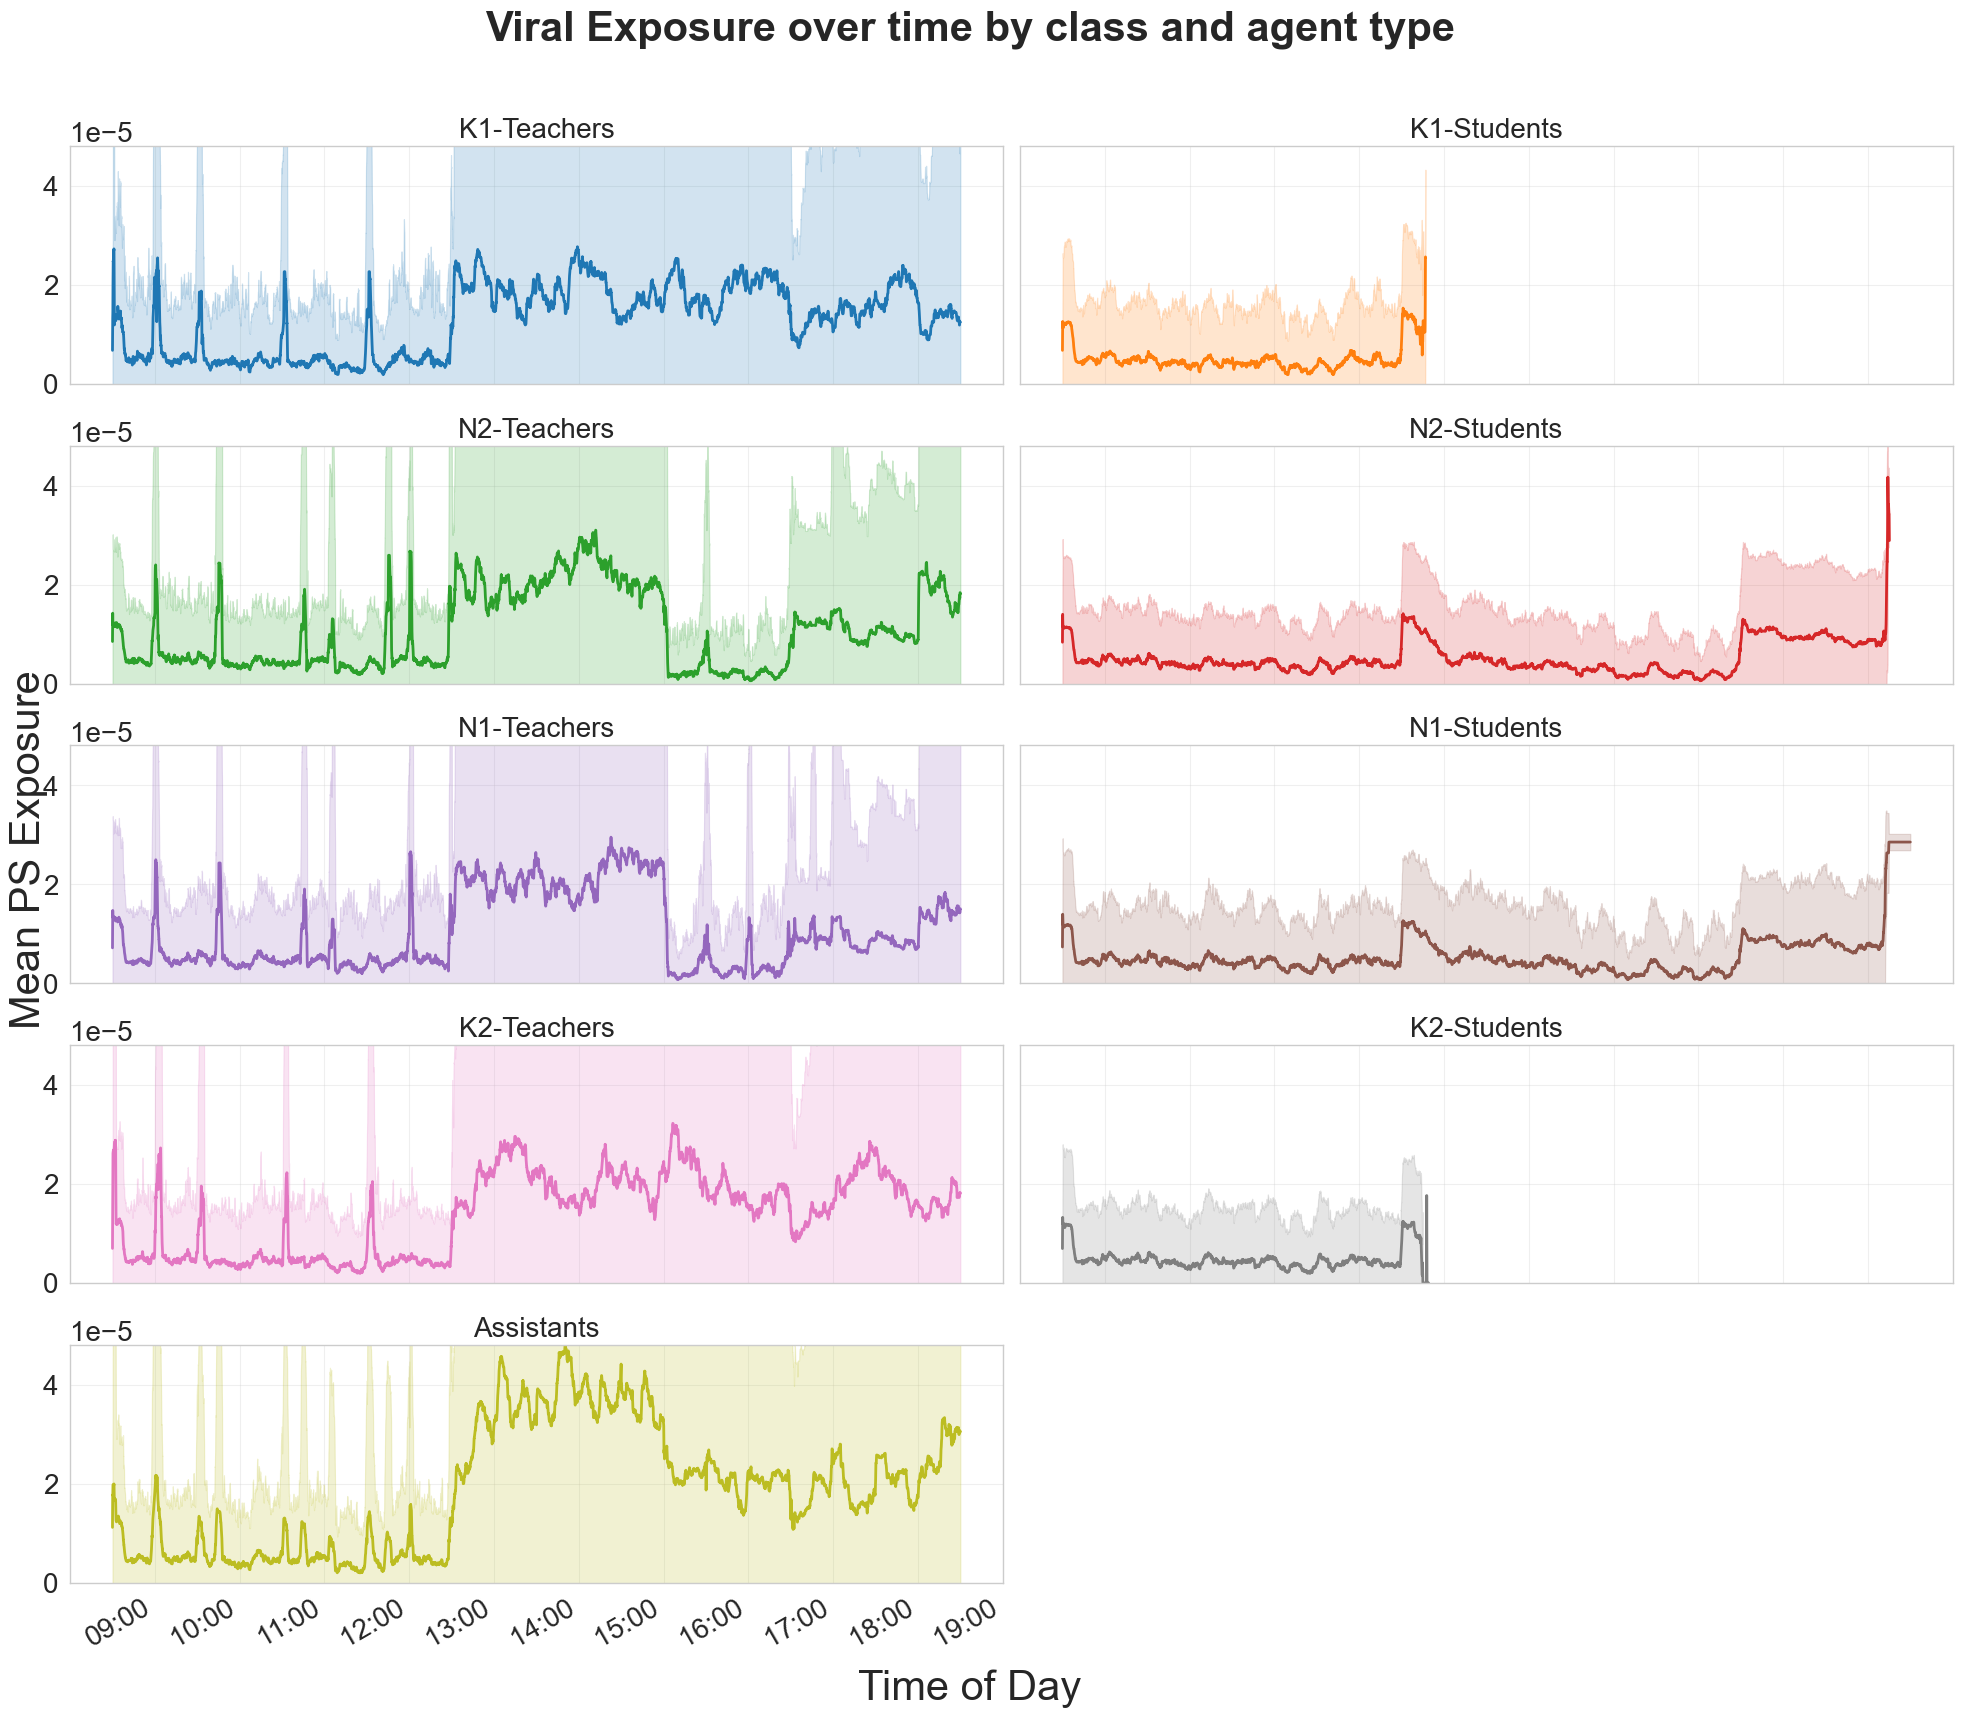

[       frame   mean_ps     sd_ps     category                datetime
 0          1  0.000007  0.000008  K1-Teachers 1900-01-01 08:30:00.400
 1          2  0.000007  0.000008  K1-Teachers 1900-01-01 08:30:00.800
 2          3  0.000008  0.000009  K1-Teachers 1900-01-01 08:30:01.200
 3          4  0.000008  0.000009  K1-Teachers 1900-01-01 08:30:01.600
 4          5  0.000009  0.000010  K1-Teachers 1900-01-01 08:30:02.000
 ...      ...       ...       ...          ...                     ...
 89996  89997  0.000012  0.000036  K1-Teachers 1900-01-01 18:29:58.800
 89997  89998  0.000012  0.000036  K1-Teachers 1900-01-01 18:29:59.200
 89998  89999  0.000012  0.000036  K1-Teachers 1900-01-01 18:29:59.600
 89999  90000  0.000012  0.000036  K1-Teachers 1900-01-01 18:30:00.000
 90000  90001  0.000012  0.000036  K1-Teachers 1900-01-01 18:30:00.400
 
 [90001 rows x 5 columns],
        frame   mean_ps     sd_ps     category                datetime
 0          1  0.000007  0.000008  K1-Students 1

In [12]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
import matplotlib.dates as mdates
from datetime import timedelta, datetime


def plot_mean_ps_over_time_by_category(
        directory="./ps_results_daily/ps_individual",
        output_dir="./special_issue_plots",
        file_prefix="daily_",
        file_suffix="_pl_student.parquet",
        frame_interval=0.4,
        max_points_per_file=90_000_000,
        show_plots=True,
        smooth_window=30  # number of frames for rolling mean smoothing
    ):
    """
    Plot mean ±1 SD passive scalar (PS) over time for multiple agent categories
    using a facet grid layout for clearer visual comparison.
    """

    id_categories = {
        'K1-Teachers': [178, 179],
        'K1-Students': [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199],
        'N2-Teachers': [200, 201],
        'N2-Students': [202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216],
        'N1-Teachers': [82, 251],
        'N1-Students': [83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94],
        'K2-Teachers': [176, 177],
        'K2-Students': [95, 96, 97, 98, 99, 100, 107, 114, 115, 116, 117, 118, 119, 135, 136, 137, 138, 139, 140, 145, 146, 147, 148, 158, 165],
        'Assistants':  [250, 252, 253, 254],
    }
        # --- Plot aesthetics ---
    sns.set_theme(style="whitegrid", context="paper")
    plt.rcParams.update({
        "axes.labelsize": 18,
        "axes.titlesize": 24,
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
        "legend.fontsize": 16,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"]
    })
    files = sorted(Path(directory).glob(f"{file_prefix}[0-9]*{file_suffix}"))
    if not files:
        raise FileNotFoundError(f"No parquet files found in {directory}")

    print(f"Found {len(files)} parquet files. Loading...")

    df_list = [pl.read_parquet(f, columns=["frame", "ps_estimated", "id"]) for f in files]
    df_all = pl.concat(df_list)
    print(f"Total rows loaded: {df_all.height:,}")

    df_all = df_all.filter(pl.col("ps_estimated").is_finite() & pl.col("frame").is_finite())

    Path(output_dir).mkdir(parents=True, exist_ok=True)
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

    all_curves = []
    start_time = datetime.strptime("08:30:00", "%H:%M:%S")

    # --- Precompute category curves ---
    for category, ids in id_categories.items():
        df_cat = df_all.filter(pl.col("id").is_in(ids))
        if df_cat.height == 0:
            continue

        df_grouped = (
            df_cat
            .group_by("frame")
            .agg([
                pl.mean("ps_estimated").alias("mean_ps"),
                pl.std("ps_estimated").alias("sd_ps")
            ])
            .sort("frame")
        )

        df_plot = df_grouped.to_pandas()
        df_plot["category"] = category
        df_plot["datetime"] = df_plot["frame"].apply(lambda f: start_time + timedelta(seconds=f * frame_interval))

        # Optional smoothing
        if smooth_window > 1:
            df_plot["mean_ps"] = df_plot["mean_ps"].rolling(window=smooth_window, min_periods=1, center=True).mean()
            df_plot["sd_ps"] = df_plot["sd_ps"].rolling(window=smooth_window, min_periods=1, center=True).mean()

        all_curves.append(df_plot)

    df_all_plot = pd.concat(all_curves, ignore_index=True)

    # --- FacetGrid for clarity ---
    n_categories = len(id_categories)
    ncols = 2
    nrows = (n_categories + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 3.5 * nrows), sharex=True, sharey=True)
    axes = axes.flatten()

    colors = sns.color_palette("tab10", n_categories)
    y_min, y_max = df_all_plot["mean_ps"].min(), df_all_plot["mean_ps"].max()

    for i, (category, df_plot) in enumerate(zip(id_categories.keys(), all_curves)):
        ax = axes[i]
        c = colors[i % len(colors)]
        ax.plot(df_plot["datetime"], df_plot["mean_ps"], color=c, linewidth=2)
        ax.fill_between(df_plot["datetime"],
                        df_plot["mean_ps"] - df_plot["sd_ps"],
                        df_plot["mean_ps"] + df_plot["sd_ps"],
                        color=c, alpha=0.2)
        ax.set_title(category, fontsize=20)
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        ax.tick_params(axis='both', labelsize=20)
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        ax.yaxis.get_offset_text().set_fontsize(20)
        ax.set_ylim(y_min, y_max)
        ax.grid(alpha=0.3)

    # Remove empty subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Viral Exposure over time by class and agent type", fontsize=30,  fontweight="bold")
    fig.supxlabel("Time of Day", fontsize=30)
    fig.supylabel("Mean PS Exposure", fontsize=30)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    save_path = Path(output_dir) / "Mean_PS_Over_Time_by_Category_Faceted.png"
    plt.savefig(save_path, dpi=600)
    print(f"Saved faceted plot -> {save_path}")

    if show_plots:
        plt.show()
    else:
        plt.close()

    return all_curves

plot_mean_ps_over_time_by_category()

Found 100 parquet files. Computing total exposures...
Saved summary plot -> special_issue_plots\Total_PS_Exposure_by_Category.png


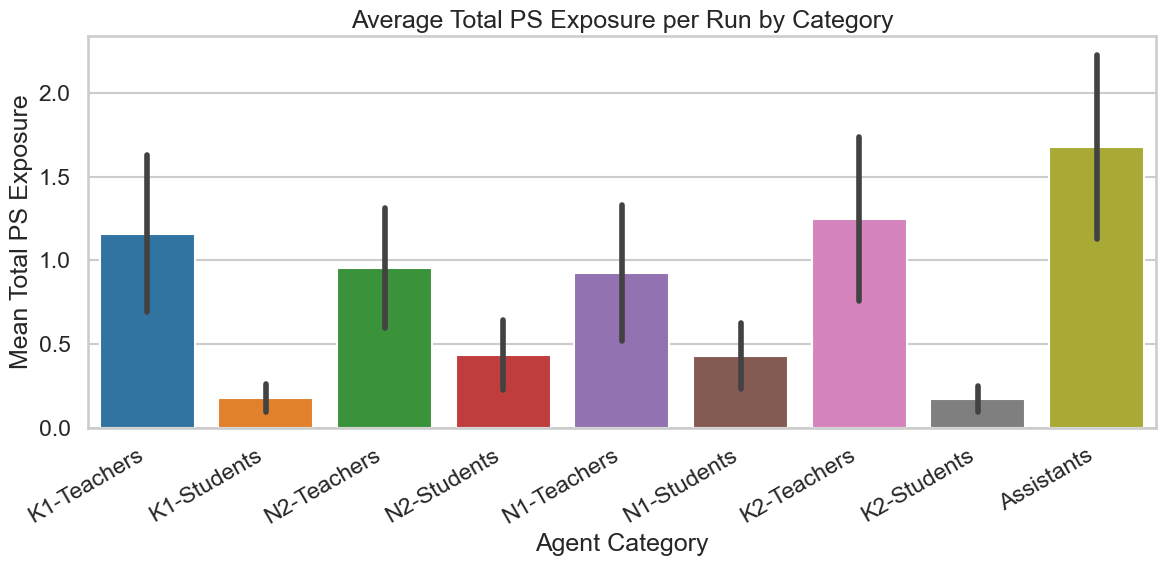

,run,category,mean_total_ps,sd_total_ps
0,105_pl_student,K1-Teachers,1.866856,0.699381
1,105_pl_student,K1-Students,0.070710,0.008952
2,105_pl_student,N2-Teachers,0.777530,0.299693
3,105_pl_student,N2-Students,0.359514,0.013898
4,105_pl_student,N1-Teachers,1.005778,0.176906
...,...,...,...,...
895,204_pl_student,N1-Teachers,1.278605,0.553071
896,204_pl_student,N1-Students,0.103417,0.007729
897,204_pl_student,K2-Teachers,0.719682,0.792313
898,204_pl_student,K2-Students,0.094312,0.003176


In [6]:
def plot_total_ps_per_run_by_category(
        directory="./ps_results_daily/ps_individual",
        output_dir="./special_issue_plots",
        file_prefix="daily_",
        file_suffix="_pl_student.parquet",
        id_categories=None,
        show_plots=True
    ):
    """
    Plot average total PS exposure per simulation run for each agent category.

    Each run (daily_xx) is treated as one experiment, and the mean ± SD of total PS
    across all agents in a category is computed per run.
    """

    import polars as pl
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from pathlib import Path

    # --- Default category mapping (same as before) ---
    if id_categories is None:
        id_categories = {
            'K1-Teachers': [178, 179],
            'K1-Students': [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199],
            'N2-Teachers': [200, 201],
            'N2-Students': [202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216],
            'N1-Teachers': [82, 251],
            'N1-Students': [83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94],
            'K2-Teachers': [176, 177],
            'K2-Students': [95, 96, 97, 98, 99, 100, 107, 114, 115, 116, 117, 118, 119, 135, 136, 137, 138, 139, 140, 145, 146, 147, 148, 158, 165],
            'Assistants':  [250, 252, 253, 254],
        }

    files = sorted(Path(directory).glob(f"{file_prefix}[0-9]*{file_suffix}"))
    if not files:
        raise FileNotFoundError(f"No parquet files found in {directory}")

    print(f"Found {len(files)} parquet files. Computing total exposures...")

    Path(output_dir).mkdir(parents=True, exist_ok=True)

    results = []
    for f in files:
        run_name = f.stem.replace(file_prefix, "").replace(file_suffix, "")
        df = pl.read_parquet(f, columns=["id", "ps_estimated"])

        # Drop invalid values
        df = df.filter(pl.col("ps_estimated").is_finite())

        # Compute total PS per agent
        df_total = df.group_by("id").agg(pl.sum("ps_estimated").alias("total_ps"))

        # Compute category totals
        for cat, ids in id_categories.items():
            df_cat = df_total.filter(pl.col("id").is_in(ids))
            if df_cat.height == 0:
                continue

            total_mean = df_cat["total_ps"].mean()
            total_sd = df_cat["total_ps"].std()
            results.append({
                "run": run_name,
                "category": cat,
                "mean_total_ps": total_mean,
                "sd_total_ps": total_sd
            })

    df_results = pd.DataFrame(results)

    # --- Plot ---
    sns.set_theme(style="whitegrid", context="talk")
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=df_results,
        x="category",
        y="mean_total_ps",
        errorbar=("sd"),
        palette="tab10"
    )
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Mean Total PS Exposure")
    plt.xlabel("Agent Category")
    plt.title("Average Total PS Exposure per Run by Category")

    save_path = Path(output_dir) / "Total_PS_Exposure_by_Category.png"
    plt.tight_layout()
    plt.savefig(save_path, dpi=600)
    print(f"Saved summary plot -> {save_path}")

    if show_plots:
        plt.show()
    else:
        plt.close()

    return df_results
plot_total_ps_per_run_by_category()

2
20
2
15
2
12
2
25
4
Found 100 parquet files. Computing total exposures...
Saved publication-ready plot -> special_issue_plots\Total_PS_Exposure_by_Category.png / .pdf


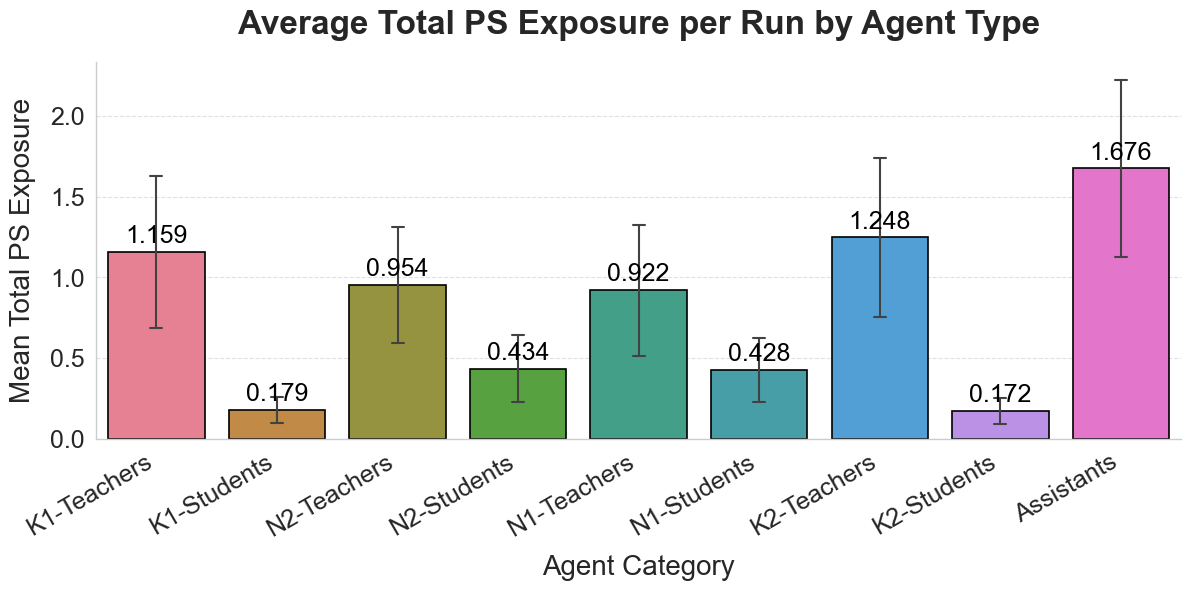

,run,category,mean_total_ps,sd_total_ps
0,105_pl_student,K1-Teachers,1.866856,0.699381
1,105_pl_student,K1-Students,0.070710,0.008952
2,105_pl_student,N2-Teachers,0.777530,0.299693
3,105_pl_student,N2-Students,0.359514,0.013898
4,105_pl_student,N1-Teachers,1.005778,0.176906
...,...,...,...,...
895,204_pl_student,N1-Teachers,1.278605,0.553071
896,204_pl_student,N1-Students,0.103417,0.007729
897,204_pl_student,K2-Teachers,0.719682,0.792313
898,204_pl_student,K2-Students,0.094312,0.003176


In [7]:
def plot_total_ps_per_run_by_category(
        directory="./ps_results_daily/ps_individual",
        output_dir="./special_issue_plots",
        file_prefix="daily_",
        file_suffix="_pl_student.parquet",
        id_categories=None,
        show_plots=True,
        annotate_bars=True
    ):
    """
    Plot mean total PS exposure per simulation run for each agent category (publication-ready).

    Produces a clean, presentation-quality bar plot showing mean ±1 SD total exposure
    across runs, with consistent aesthetics and labeling.
    """

    import polars as pl
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from pathlib import Path

    # --- Category mapping ---
    if id_categories is None:
        id_categories = {
            'K1-Teachers': [178, 179],
            'K1-Students': [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199],
            'N2-Teachers': [200, 201],
            'N2-Students': [202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216],
            'N1-Teachers': [82, 251],
            'N1-Students': [83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94],
            'K2-Teachers': [176, 177],
            'K2-Students': [95, 96, 97, 98, 99, 100, 107, 114, 115, 116, 117, 118, 119, 135, 136, 137, 138, 139, 140, 145, 146, 147, 148, 158, 165],
            'Assistants':  [250, 252, 253, 254],
        }

    for id_len in id_categories.values():
        print(len(id_len))
        
    files = sorted(Path(directory).glob(f"{file_prefix}[0-9]*{file_suffix}"))
    if not files:
        raise FileNotFoundError(f"No parquet files found in {directory}")

    print(f"Found {len(files)} parquet files. Computing total exposures...")

    Path(output_dir).mkdir(parents=True, exist_ok=True)

    results = []
    for f in files:
        run_name = f.stem.replace(file_prefix, "").replace(file_suffix, "")
        df = pl.read_parquet(f, columns=["id", "ps_estimated"])
        df = df.filter(pl.col("ps_estimated").is_finite())

        df_total = df.group_by("id").agg(pl.sum("ps_estimated").alias("total_ps"))

        for cat, ids in id_categories.items():
            df_cat = df_total.filter(pl.col("id").is_in(ids))
            if df_cat.height == 0:
                continue

            results.append({
                "run": run_name,
                "category": cat,
                "mean_total_ps": df_cat["total_ps"].mean(),
                "sd_total_ps": df_cat["total_ps"].std()
            })

    df_results = pd.DataFrame(results)

    # --- Plot aesthetics ---
    sns.set_theme(style="whitegrid", context="paper")
    plt.rcParams.update({
        "axes.labelsize": 20,
        "axes.titlesize": 24,
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
        "legend.fontsize": 18,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"]
    })

    plt.figure(figsize=(12, 6))
    palette = sns.color_palette("husl", n_colors=len(df_results["category"].unique()))

    ax = sns.barplot(
        data=df_results,
        x="category",
        y="mean_total_ps",
        errorbar=("sd"),
        palette=palette,
        capsize=0.1,
        errwidth=1.5,
        linewidth=1.2,
        edgecolor="black"
    )

    # Annotate mean values on bars
    if annotate_bars:
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f"{height:.3f}",
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom',
                        fontsize=18, color='black',
                        xytext=(0, 3), textcoords='offset points')

    # --- Labels and style ---
    plt.xticks(rotation=30, ha="right")
    plt.xlabel("Agent Category", labelpad=10)
    plt.ylabel("Mean Total PS Exposure", labelpad=10)
    plt.title("Average Total PS Exposure per Run by Agent Type", pad=20, weight="bold")

    sns.despine(left=False, bottom=False)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()

    # --- Save high-quality outputs ---
    save_base = Path(output_dir) / "Total_PS_Exposure_by_Category"
    plt.savefig(f"{save_base}.png", dpi=600, bbox_inches="tight")
    plt.savefig(f"{save_base}.pdf", bbox_inches="tight")
    print(f"Saved publication-ready plot -> {save_base}.png / .pdf")

    if show_plots:
        plt.show()
    else:
        plt.close()

    return df_results
plot_total_ps_per_run_by_category()

Found 100 parquet files. Computing durations per room...
Saved faceted publication-ready plot -> special_issue_plots\Duration_Per_Room_by_Category_Faceted.png / .pdf


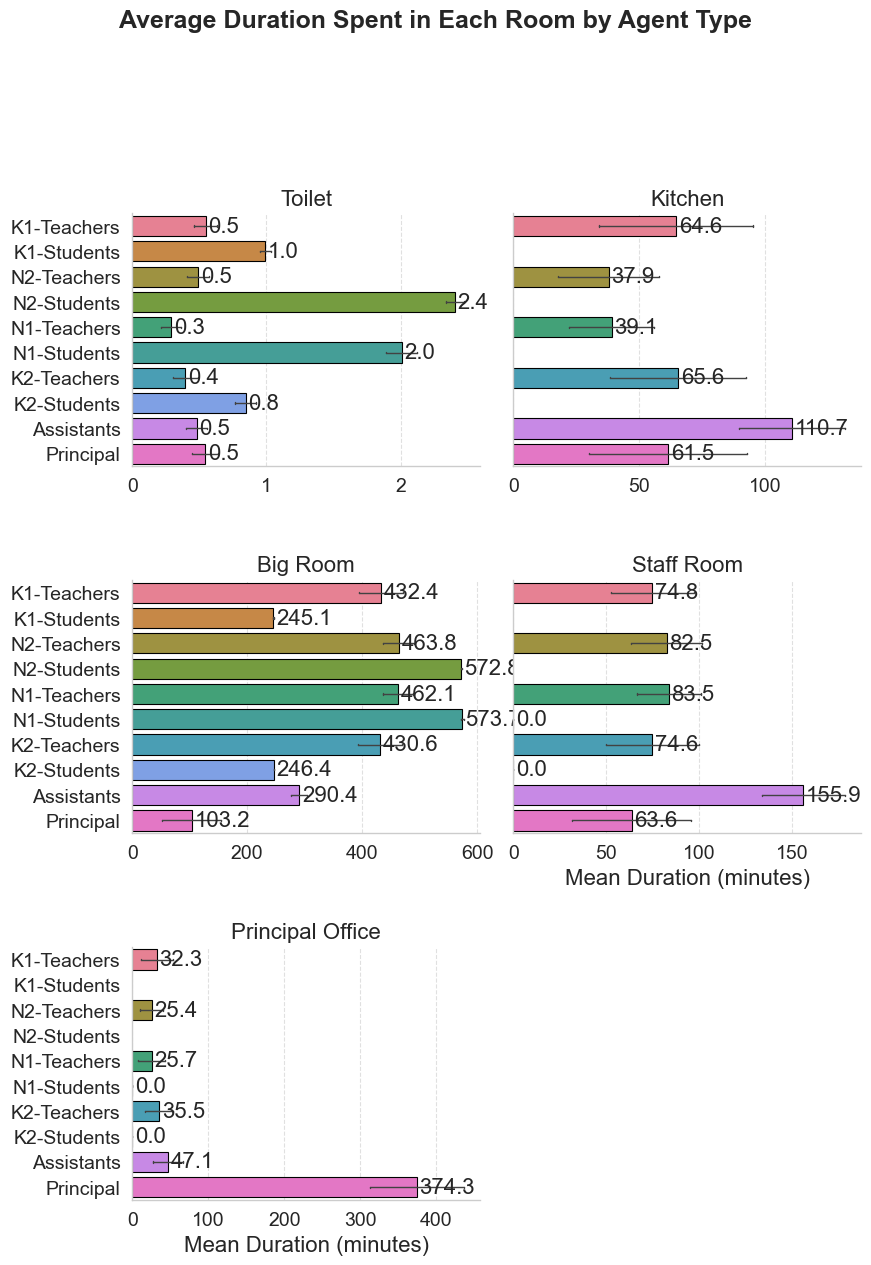

,run,category,room,mean_duration_min,sd_duration_min
0,105_pl_student,K1-Teachers,Toilet,0.546667,0.094281
1,105_pl_student,K1-Teachers,Kitchen,59.316667,9.055681
2,105_pl_student,K1-Teachers,Big Room,394.136667,56.262130
3,105_pl_student,K1-Teachers,Staff Room,102.860000,42.200133
4,105_pl_student,K1-Teachers,Principal Office,43.146667,4.912035
...,...,...,...,...,...
3899,204_pl_student,Principal,Big Room,20.980000,NaN
3900,204_pl_student,Principal,Staff Room,79.426667,NaN
3901,204_pl_student,Principal,Kitchen,30.080000,NaN
3902,204_pl_student,Principal,Principal Office,469.073333,NaN


In [8]:
def plot_duration_per_room_by_category(
        directory="./ps_results_daily/ps_individual",
        source_directory="./ps_results_daily/source_data",
        output_dir="./special_issue_plots",
        file_prefix="daily_",
        file_suffix="_pl_student.parquet",
        id_categories=None,
        room_labels=None,
        show_plots=True,
        annotate_bars=True
    ):
    """
    Plot mean total duration spent (minutes) in each room by agent category across runs.
    Uses a faceted horizontal bar layout for better readability.
    """

    import polars as pl
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from pathlib import Path

    # --- Default mappings ---
    if id_categories is None:
        id_categories = {
            'K1-Teachers': [178, 179],
            'K1-Students': [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199],
            'N2-Teachers': [200, 201],
            'N2-Students': [202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216],
            'N1-Teachers': [82, 251],
            'N1-Students': [83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94],
            'K2-Teachers': [176, 177],
            'K2-Students': [95, 96, 97, 98, 99, 100, 107, 114, 115, 116, 117, 118, 119, 135, 136, 137, 138, 139, 140, 145, 146, 147, 148, 158, 165],
            'Assistants':  [250, 252, 253, 254],
            'Principal': [2]
        }

    if room_labels is None:
        room_labels = {
            0: "Big Room",
            1: "Staff Room",
            2: "Principal Office",
            3: "Kitchen",
            4: "Toilet"
        }

    files = sorted(Path(directory).glob(f"{file_prefix}[0-9]*{file_suffix}"))
    a_files = sorted(Path(source_directory).glob(f"{file_prefix}[0-9]*{file_suffix}"))
    if not files:
        raise FileNotFoundError(f"No parquet files found in {directory}")

    print(f"Found {len(files)} parquet files. Computing durations per room...")

    Path(output_dir).mkdir(parents=True, exist_ok=True)
    results = []

    # --- Compute duration per category per room per run ---
    for f in files:
        run_name = f.stem.replace(file_prefix, "").replace(file_suffix, "")
        df = pl.read_parquet(f, columns=["id", "room", "frame"]).filter(pl.col("room").is_not_null())
        df_room = df.group_by(["id", "room"]).agg(pl.count("frame").alias("frame_count"))
        df_room = df_room.with_columns((pl.col("frame_count") * 0.4 / 60).alias("duration_min"))

        for cat, ids in id_categories.items():
            df_cat = df_room.filter(pl.col("id").is_in(ids))
            if df_cat.height == 0:
                continue

            df_cat_room = df_cat.group_by("room").agg(
                pl.mean("duration_min").alias("mean_duration_min"),
                pl.std("duration_min").alias("sd_duration_min")
            )

            for row in df_cat_room.iter_rows(named=True):
                results.append({
                    "run": run_name,
                    "category": cat,
                    "room": room_labels.get(row["room"], f"Room {row['room']}"),
                    "mean_duration_min": row["mean_duration_min"],
                    "sd_duration_min": row["sd_duration_min"]
                })

    # --- Principal files ---
    for f in a_files:
        run_name = f.stem.replace(file_prefix, "").replace(file_suffix, "")
        df = pl.read_parquet(f, columns=["id", "room", "frame"]).filter(pl.col("room").is_not_null())
        df_room = df.group_by(["id", "room"]).agg(pl.count("frame").alias("frame_count"))
        df_room = df_room.with_columns((pl.col("frame_count") * 0.4 / 60).alias("duration_min"))

        df_cat_room = df_room.group_by("room").agg(
            pl.mean("duration_min").alias("mean_duration_min"),
            pl.std("duration_min").alias("sd_duration_min")
        )

        for row in df_cat_room.iter_rows(named=True):
            results.append({
                "run": run_name,
                "category": "Principal",
                "room": room_labels.get(row["room"], f"Room {row['room']}"),
                "mean_duration_min": row["mean_duration_min"],
                "sd_duration_min": row["sd_duration_min"]
            })

    df_results = pd.DataFrame(results)

    # --- Plot aesthetics ---
    sns.set_theme(style="whitegrid", context="paper")
    plt.rcParams.update({
        "axes.labelsize": 16,
        "axes.titlesize": 22,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 12,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"]
    })

    # --- Faceted horizontal bar plot ---
    g = sns.catplot(
        data=df_results,
        kind="bar",
        x="mean_duration_min",
        y="category",
        col="room",
        col_wrap=2,
        errorbar=("sd"),
        palette="husl",
        height=4,
        aspect=1.1,
        capsize=0.05,
        errwidth=1.0,
        linewidth=0.8,
        edgecolor="black",
        sharex=False
    )

    g.set_axis_labels("Mean Duration (minutes)", "")
    g.set_titles("{col_name}")
    g.tight_layout()
    g.fig.subplots_adjust(top=0.88, hspace=0.45)

    # --- Optional bar annotation ---
    if annotate_bars:
        for ax in g.axes.flatten():
            for c in ax.containers:
                labels = [f"{v.get_width():.1f}" for v in c]
                ax.bar_label(c, labels=labels, label_type="edge", fontsize=16, padding=2)

    for ax in g.axes.flatten():
        ax.grid(axis="x", linestyle="--", alpha=0.6)
        ax.set_xlim(left=0)

    plt.suptitle("Average Duration Spent in Each Room by Agent Type", fontsize=18, weight="bold", y=1.05)

    # --- Save ---
    save_base = Path(output_dir) / "Duration_Per_Room_by_Category_Faceted"
    plt.savefig(f"{save_base}.png", dpi=600, bbox_inches="tight")
    plt.savefig(f"{save_base}.pdf", bbox_inches="tight")
    print(f"Saved faceted publication-ready plot -> {save_base}.png / .pdf")

    if show_plots:
        plt.show()
    else:
        plt.close()

    return df_results


plot_duration_per_room_by_category()

Found 100 individual files and 100 principal files. Computing co-presence durations...
Saved plot -> special_issue_plots\Duration_With_Principal_By_Category.png / .pdf


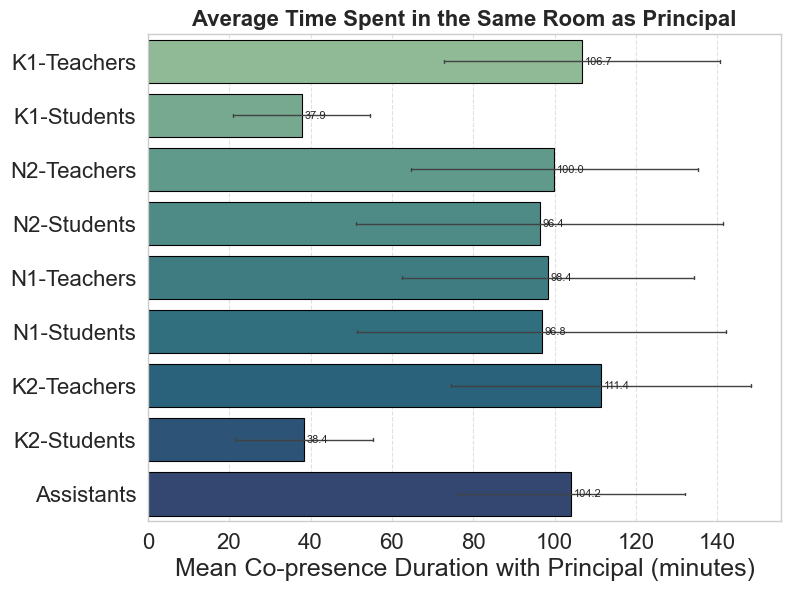

,run,category,mean_duration_min,sd_duration_min
0,105_pl_student,K1-Teachers,122.936667,5.633284
1,105_pl_student,K1-Students,12.854000,2.016597
2,105_pl_student,N2-Teachers,72.613333,23.325096
3,105_pl_student,N2-Students,78.943111,1.933366
4,105_pl_student,N1-Teachers,83.843333,15.363073
...,...,...,...,...
895,204_pl_student,N1-Teachers,67.073333,23.598510
896,204_pl_student,N1-Students,20.980000,0.000000
897,204_pl_student,K2-Teachers,42.106667,32.932320
898,204_pl_student,K2-Students,20.245333,0.091125


In [9]:
def plot_duration_with_principal_by_category(
        directory="./ps_results_daily/ps_individual",
        source_directory="./ps_results_daily/source_data",
        output_dir="./special_issue_plots",
        file_prefix="daily_",
        file_suffix="_pl_student.parquet",
        id_categories=None,
        show_plots=True,
        annotate_bars=True
    ):
    """
    Plot mean total duration (minutes) where agents from each category share the same room
    as the Principal across all simulation runs.

    The function compares frame-by-frame room occupancy of each agent with the Principal
    and sums durations where both are in the same room.
    """

    import polars as pl
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from pathlib import Path

    # --- Default mappings ---
    if id_categories is None:
        id_categories = {
            'K1-Teachers': [178, 179],
            'K1-Students': [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199],
            'N2-Teachers': [200, 201],
            'N2-Students': [202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216],
            'N1-Teachers': [82, 251],
            'N1-Students': [83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94],
            'K2-Teachers': [176, 177],
            'K2-Students': [95, 96, 97, 98, 99, 100, 107, 114, 115, 116, 117, 118, 119, 135, 136, 137, 138, 139, 140, 145, 146, 147, 148, 158, 165],
            'Assistants':  [250, 252, 253, 254],
            'Principal': [2]
        }

    # --- Locate files ---
    files = sorted(Path(directory).glob(f"{file_prefix}[0-9]*{file_suffix}"))
    principal_files = sorted(Path(source_directory).glob(f"{file_prefix}[0-9]*{file_suffix}"))
    if not files or not principal_files:
        raise FileNotFoundError("Required parquet files not found in the given directories.")

    print(f"Found {len(files)} individual files and {len(principal_files)} principal files. Computing co-presence durations...")

    Path(output_dir).mkdir(parents=True, exist_ok=True)
    results = []

    # --- Iterate over runs ---
    for f, f_principal in zip(files, principal_files):
        run_name = f.stem.replace(file_prefix, "").replace(file_suffix, "")
        df_agents = pl.read_parquet(f, columns=["id", "room", "frame"]).filter(pl.col("room").is_not_null())
        df_principal = pl.read_parquet(f_principal, columns=["id", "room", "frame"]).filter(pl.col("room").is_not_null())

        # Principal's room occupancy per frame
        df_principal = df_principal.filter(pl.col("id") == 2).select(["frame", "room"])
        df_principal = df_principal.rename({"room": "principal_room"})
        # Join to compare agent and principal room per frame
        df_agents = df_agents.with_columns(pl.col("frame").cast(pl.Int64))
        df_principal = df_principal.with_columns(pl.col("frame").cast(pl.Int64))

        # Join to compare agent and principal room per frame
        df_joined = df_agents.join(df_principal, on="frame", how="inner")
        df_same_room = df_joined.filter(pl.col("room") == pl.col("principal_room"))

        # Compute total co-presence time (in minutes)
        df_same_room = df_same_room.group_by("id").agg(pl.count("frame").alias("shared_frames"))
        df_same_room = df_same_room.with_columns((pl.col("shared_frames") * 0.4 / 60).alias("duration_min"))

        # --- Aggregate by category ---
        for cat, ids in id_categories.items():
            if cat == "Principal":
                continue
            df_cat = df_same_room.filter(pl.col("id").is_in(ids))
            if df_cat.height == 0:
                continue

            mean_duration = df_cat["duration_min"].mean()
            sd_duration = df_cat["duration_min"].std()

            results.append({
                "run": run_name,
                "category": cat,
                "mean_duration_min": mean_duration,
                "sd_duration_min": sd_duration
            })

    df_results = pd.DataFrame(results)

    # --- Plot aesthetics ---
    sns.set_theme(style="whitegrid", context="paper")
    plt.rcParams.update({
        "axes.labelsize": 18,
        "axes.titlesize": 24,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 14,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"]
    })

    # --- Horizontal bar plot ---
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(
        data=df_results,
        x="mean_duration_min",
        y="category",
        errorbar=("sd"),
        palette="crest",
        capsize=0.05,
        errwidth=1.0,
        linewidth=0.8,
        edgecolor="black"
    )

    ax.set_xlabel("Mean Co-presence Duration with Principal (minutes)")
    ax.set_ylabel("")
    ax.set_title("Average Time Spent in the Same Room as Principal", fontsize=16, weight="bold")

    if annotate_bars:
        for container in ax.containers:
            labels = [f"{v.get_width():.1f}" for v in container]
            ax.bar_label(container, labels=labels, label_type="edge", fontsize=8, padding=2)

    ax.grid(axis="x", linestyle="--", alpha=0.6)
    ax.set_xlim(left=0)
    plt.tight_layout()

    # --- Save outputs ---
    save_base = Path(output_dir) / "Duration_With_Principal_By_Category"
    plt.savefig(f"{save_base}.png", dpi=600, bbox_inches="tight")
    plt.savefig(f"{save_base}.pdf", bbox_inches="tight")
    print(f"Saved plot -> {save_base}.png / .pdf")

    if show_plots:
        plt.show()
    else:
        plt.close()

    return df_results


# Example call
plot_duration_with_principal_by_category()


Found 100 individual files and 100 principal files. Computing co-presence durations by room...
Saved faceted publication-ready plot -> special_issue_plots\Duration_With_Principal_By_Category_Faceted.png / .pdf


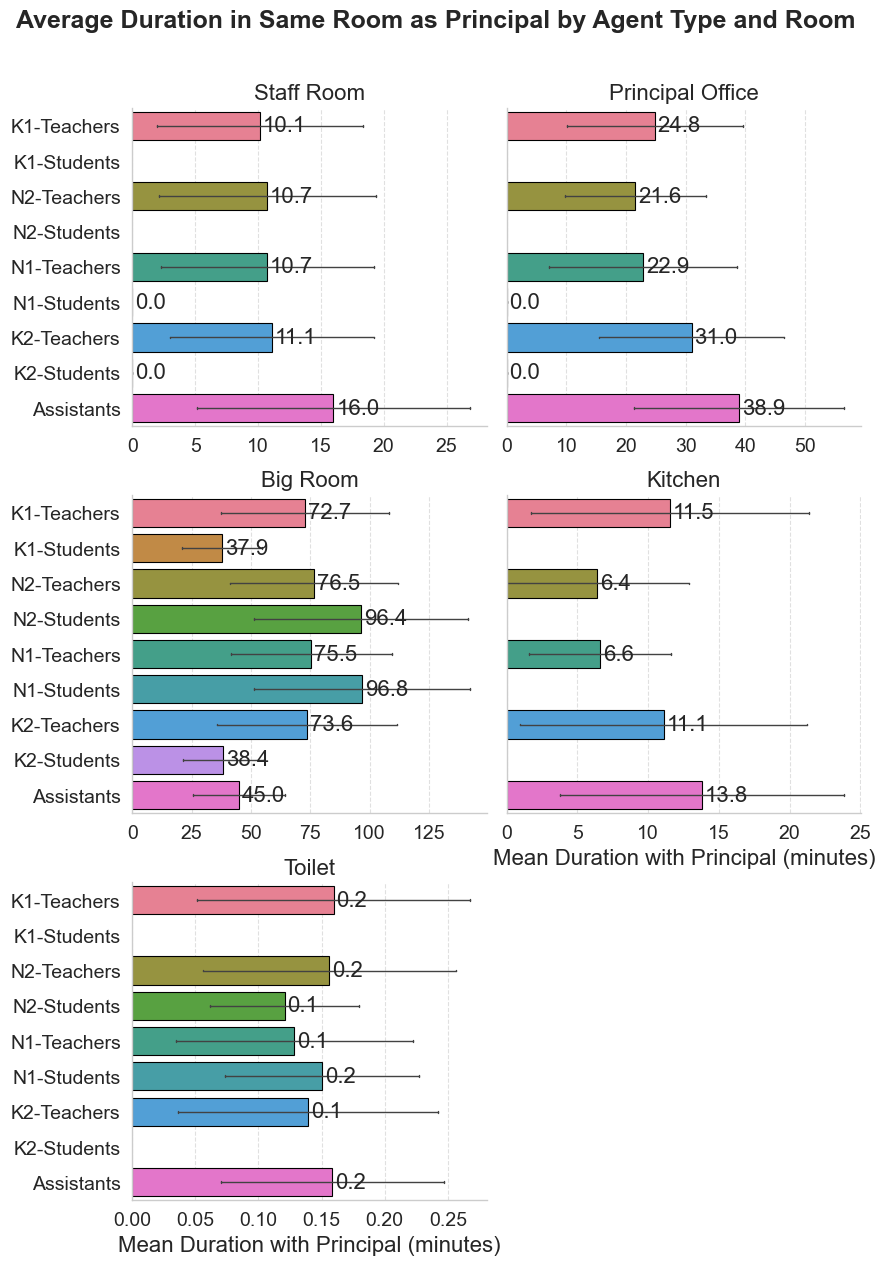

,run,category,room,mean_duration_min,sd_duration_min
0,105_pl_student,K1-Teachers,Staff Room,5.553333,2.875568
1,105_pl_student,K1-Teachers,Principal Office,43.146667,4.912035
2,105_pl_student,K1-Teachers,Big Room,56.936667,26.620213
3,105_pl_student,K1-Teachers,Kitchen,34.600000,NaN
4,105_pl_student,K1-Students,Big Room,12.854000,2.016597
...,...,...,...,...,...
2475,204_pl_student,Assistants,Big Room,17.646667,2.478787
2476,204_pl_student,Assistants,Staff Room,12.111667,13.412514
2477,204_pl_student,Assistants,Principal Office,14.620000,11.158759
2478,204_pl_student,Assistants,Toilet,0.066667,NaN


In [11]:
def plot_duration_with_principal_by_category_by_room(
        directory="./ps_results_daily/ps_individual",
        source_directory="./ps_results_daily/source_data",
        output_dir="./special_issue_plots",
        file_prefix="daily_",
        file_suffix="_pl_student.parquet",
        id_categories=None,
        room_labels=None,
        show_plots=True,
        annotate_bars=True
    ):
    """
    Plot mean total duration (minutes) where agents from each category share the same room
    as the Principal, split by room across all simulation runs.
    """

    import polars as pl
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from pathlib import Path

    # --- Default mappings ---
    if id_categories is None:
        id_categories = {
            'K1-Teachers': [178, 179],
            'K1-Students': [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199],
            'N2-Teachers': [200, 201],
            'N2-Students': [202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216],
            'N1-Teachers': [82, 251],
            'N1-Students': [83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94],
            'K2-Teachers': [176, 177],
            'K2-Students': [95, 96, 97, 98, 99, 100, 107, 114, 115, 116, 117, 118, 119, 135, 136, 137, 138, 139, 140, 145, 146, 147, 148, 158, 165],
            'Assistants':  [250, 252, 253, 254],
            'Principal': [2]
        }

    if room_labels is None:
        room_labels = {
            0: "Big Room",
            1: "Staff Room",
            2: "Principal Office",
            3: "Kitchen",
            4: "Toilet"
        }

    # --- Locate files ---
    files = sorted(Path(directory).glob(f"{file_prefix}[0-9]*{file_suffix}"))
    principal_files = sorted(Path(source_directory).glob(f"{file_prefix}[0-9]*{file_suffix}"))
    if not files or not principal_files:
        raise FileNotFoundError("Required parquet files not found in the given directories.")

    print(f"Found {len(files)} individual files and {len(principal_files)} principal files. Computing co-presence durations by room...")

    Path(output_dir).mkdir(parents=True, exist_ok=True)
    results = []

    # --- Iterate over runs ---
    for f, f_principal in zip(files, principal_files):
        run_name = f.stem.replace(file_prefix, "").replace(file_suffix, "")
        df_agents = pl.read_parquet(f, columns=["id", "room", "frame"]).filter(pl.col("room").is_not_null())
        df_principal = pl.read_parquet(f_principal, columns=["id", "room", "frame"]).filter(pl.col("room").is_not_null())

        # --- Ensure frame dtypes match ---
        df_agents = df_agents.with_columns(pl.col("frame").cast(pl.Int64))
        df_principal = df_principal.with_columns(pl.col("frame").cast(pl.Int64))

        # --- Principal room per frame ---
        df_principal = df_principal.filter(pl.col("id") == 2).rename({"room": "principal_room"}).select(["frame", "principal_room"])

        # --- Join and check co-presence ---
        df_joined = df_agents.join(df_principal, on="frame", how="inner")
        df_same_room = df_joined.filter(pl.col("room") == pl.col("principal_room"))

        # --- Compute duration in minutes ---
        df_same_room = df_same_room.with_columns((pl.lit(0.4) * pl.col("frame") * 0 + 0.4 / 60).alias("frame_duration_min"))  # just 0.4/60 per frame
        df_same_room = df_same_room.group_by(["id", "room"]).agg(pl.sum("frame_duration_min").alias("duration_min"))

        # --- Aggregate by category ---
        for cat, ids in id_categories.items():
            if cat == "Principal":
                continue
            df_cat = df_same_room.filter(pl.col("id").is_in(ids))
            if df_cat.height == 0:
                continue

            df_cat_room = df_cat.group_by("room").agg([
                pl.mean("duration_min").alias("mean_duration_min"),
                pl.std("duration_min").alias("sd_duration_min")
            ])


            for row in df_cat_room.iter_rows(named=True):
                results.append({
                    "run": run_name,
                    "category": cat,
                    "room": room_labels.get(row["room"], f"Room {row['room']}"),
                    "mean_duration_min": row["mean_duration_min"],
                    "sd_duration_min": row["sd_duration_min"]
                })

    df_results = pd.DataFrame(results)

    # --- Plot aesthetics ---
    sns.set_theme(style="whitegrid", context="paper")
    plt.rcParams.update({
        "axes.labelsize": 16,
        "axes.titlesize": 22,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 12,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"]
    })

    # --- Faceted horizontal bar plot ---
    g = sns.catplot(
        data=df_results,
        kind="bar",
        x="mean_duration_min",
        y="category",
        col="room",
        col_wrap=2,
        errorbar=("sd"),
        palette="husl",
        height=4,
        aspect=1.1,
        capsize=0.05,
        errwidth=1.0,
        linewidth=0.8,
        edgecolor="black",
        sharex=False
    )

    g.set_axis_labels("Mean Duration with Principal (minutes)", "")
    g.set_titles("{col_name}")
    g.tight_layout()

    # --- Optional bar annotation ---
    if annotate_bars:
        for ax in g.axes.flatten():
            for c in ax.containers:
                labels = [f"{v.get_width():.1f}" for v in c]
                ax.bar_label(c, labels=labels, label_type="edge", fontsize=16, padding=2)

    for ax in g.axes.flatten():
        ax.grid(axis="x", linestyle="--", alpha=0.6)
        ax.set_xlim(left=0)

    plt.suptitle("Average Duration in Same Room as Principal by Agent Type and Room", fontsize=18, weight="bold", y=1.05)

    # --- Save ---
    save_base = Path(output_dir) / "Duration_With_Principal_By_Category_Faceted"
    plt.savefig(f"{save_base}.png", dpi=600, bbox_inches="tight")
    plt.savefig(f"{save_base}.pdf", bbox_inches="tight")
    print(f"Saved faceted publication-ready plot -> {save_base}.png / .pdf")

    if show_plots:
        plt.show()
    else:
        plt.close()

    return df_results
plot_duration_with_principal_by_category_by_room()